**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). 
The total score must be re-scaled to 100 -- that should apply to all future assignments so that Canvas assigns the same weight on all assignments.

In the case a question is stated to worth 8 points, grade on a 0-4 scale, and multiply by 2.



In [ ]:
# Grader's area
import numpy as np
G = np.zeros([10,10])
maxScore = 0


# **Assignment 6**
<br>

<font>

In [1]:
from IPython.display import Math
from IPython.display import Latex

import numpy as np
import os
import struct

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier

import torch
import torchvision
from torchvision import datasets, transforms 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

----------------
----------------
----------------

## <font color='blue'> **Question 1.** Visualizing convergence. </font>

Modify this code so that in every epoch it records:

**a.** The test loss [4 pt] <br>
**b.** The training accuracy [4 pt] <br>
**c.** The test accuracy [4pt] 

Then:

**d.** Run the model for 20 epochs and give two plots (one for losses, one for accuracies) for the convergence behavior over 20 epochs. [4pt]

<br>

**Note:**
Make sure you avoid updating the weights when you use the test set. For that you should consult the notebook from CNNs lecture. 




In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x


net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(net.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)>


In [ ]:
def eval_loss_and_accuracy(input_loader, epoch):
  
  eval_losses=[]
  eval_accu=[]
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)

  start.record()
  for epoch in range(epoch):  # loop over the dataset multiple times

      running_loss=0.0
      accuracy=0.0
      total =0.0
      correct=0.0
      for i, data in enumerate(input_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0         
          
          #Calculated prediction labels from models
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          
          #Comparing predicted and true labels
          correct += (predicted == labels).sum().item()
      accuracy = (100 * correct / total)
      print(f'Accuracy is {accuracy:.1f} %')

      eval_losses.append(round(running_loss/len(input_loader),3))            
      eval_accu.append(round(accuracy,3))      

  end.record()
  # Waits for everything to finish running
  torch.cuda.synchronize()

  
  print(start.elapsed_time(end))  # milliseconds
  return eval_losses,eval_accu;

In [ ]:
#b. The training accuracy [4 pt]
train_loss_list,train_accu_list = eval_loss_and_accuracy(trainloader,20)
print('Finished Training')

[1,  2000] loss: 1.597
[1,  4000] loss: 1.542
[1,  6000] loss: 1.537
[1,  8000] loss: 1.506
[1, 10000] loss: 1.473
[1, 12000] loss: 1.461
Accuracy is 45.6 %
[2,  2000] loss: 1.396
[2,  4000] loss: 1.405
[2,  6000] loss: 1.396
[2,  8000] loss: 1.384
[2, 10000] loss: 1.364
[2, 12000] loss: 1.366
Accuracy is 50.8 %
[3,  2000] loss: 1.308
[3,  4000] loss: 1.311
[3,  6000] loss: 1.285
[3,  8000] loss: 1.265
[3, 10000] loss: 1.264
[3, 12000] loss: 1.267
Accuracy is 55.1 %
[4,  2000] loss: 1.222
[4,  4000] loss: 1.227
[4,  6000] loss: 1.211
[4,  8000] loss: 1.207
[4, 10000] loss: 1.209
[4, 12000] loss: 1.204
Accuracy is 57.6 %
[5,  2000] loss: 1.133
[5,  4000] loss: 1.147
[5,  6000] loss: 1.154
[5,  8000] loss: 1.173
[5, 10000] loss: 1.167
[5, 12000] loss: 1.172
Accuracy is 59.5 %
[6,  2000] loss: 1.079
[6,  4000] loss: 1.098
[6,  6000] loss: 1.123
[6,  8000] loss: 1.106
[6, 10000] loss: 1.117
[6, 12000] loss: 1.142
Accuracy is 61.4 %
[7,  2000] loss: 1.051
[7,  4000] loss: 1.077
[7,  6000] l

In [ ]:
### Your code here. Also give some comments about your findings

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
#a. The test loss [4 pt]
#c. The test accuracy [4pt]
test_loss_list,test_accu_list = eval_loss_and_accuracy(testloader,20)
print('Finished Testing')

[1,  2000] loss: 1.267
Accuracy is 57.7 %
[2,  2000] loss: 1.084
Accuracy is 62.6 %
[3,  2000] loss: 0.985
Accuracy is 66.0 %
[4,  2000] loss: 0.910
Accuracy is 68.6 %
[5,  2000] loss: 0.842
Accuracy is 70.5 %
[6,  2000] loss: 0.759
Accuracy is 72.8 %
[7,  2000] loss: 0.707
Accuracy is 75.6 %
[8,  2000] loss: 0.651
Accuracy is 77.1 %
[9,  2000] loss: 0.637
Accuracy is 77.6 %
[10,  2000] loss: 0.576
Accuracy is 80.0 %
[11,  2000] loss: 0.548
Accuracy is 80.8 %
[12,  2000] loss: 0.521
Accuracy is 81.8 %
[13,  2000] loss: 0.499
Accuracy is 82.8 %
[14,  2000] loss: 0.474
Accuracy is 83.4 %
[15,  2000] loss: 0.467
Accuracy is 84.0 %
[16,  2000] loss: 0.440
Accuracy is 84.8 %
[17,  2000] loss: 0.447
Accuracy is 85.0 %
[18,  2000] loss: 0.427
Accuracy is 85.9 %
[19,  2000] loss: 0.391
Accuracy is 87.2 %
[20,  2000] loss: 0.387
Accuracy is 87.6 %
204211.796875
Finished Testing


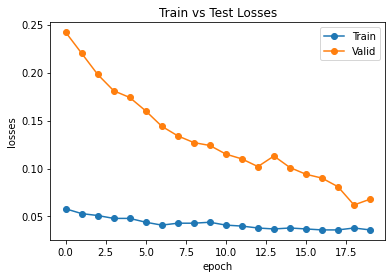

In [ ]:
#d. Run the model for 20 epochs and give two plots (one for losses, one for accuracies) for the convergence behavior over 20 epochs. [4pt]
plt.plot(train_loss_list,'-o')
plt.plot(test_loss_list,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Losses')

plt.show()


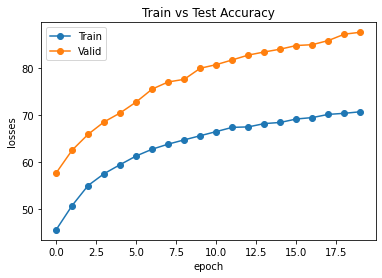

In [ ]:
#d. Run the model for 20 epochs and give two plots (one for losses, one for accuracies) for the convergence behavior over 20 epochs. [4pt]
plt.plot(train_accu_list,'-o')
plt.plot(test_accu_list,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Accuracy')

plt.show()

From the above plots, accuracy is better in training set. And as the iteration increases loss decreases too.

In [ ]:
# For grader use only

# insert grade here
# G[1,1] =   
# G[1,2] = 
# G[1,3] =
# G[1,4] = 


maxScore = maxScore + 16


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 2.** Learning random labels. </font>

Reuse the above code, but instead of using the given input labels on the training set, use random labels. Then run for 40 epochs. 
<br>

**a.** Report the plots for the training accuracy. **[4 pt]** <br>
**b.** What is the final training accuracy? **[4 pt]** <br>
**c.** What would be the expected accuracy for a random baseline model? **[4 pt]**





In [ ]:
## your code goes here
import torchvision 
import torch
import torch.optim as optim
import random

batch_size = 4

new_trainset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

for i in range(len(new_trainset.targets)):
  new_trainset.targets[i] = random.randint(0, 9)

print(testset.targets) 
print("after label change",new_trainset.targets)
trainloader_rand = torch.utils.data.DataLoader(new_trainset, batch_size=batch_size,   shuffle=False, num_workers=2)

new_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

traindataiter_rand = iter(trainloader_rand)
trainimages_rand, trainlabels_rand = traindataiter_rand.next()

Files already downloaded and verified
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3

In [ ]:
num_epochs = 40
train_loss_list_rand, train_accu_list_rand = eval_loss_and_accuracy(trainloader_rand,num_epochs)
print('Finished Training')

[1,  2000] loss: 2.468
Accuracy is 10.6 %
[2,  2000] loss: 2.303
Accuracy is 10.2 %
[3,  2000] loss: 2.302
Accuracy is 10.2 %
[4,  2000] loss: 2.302
Accuracy is 10.2 %
[5,  2000] loss: 2.302
Accuracy is 10.2 %
[6,  2000] loss: 2.302
Accuracy is 10.2 %
[7,  2000] loss: 2.302
Accuracy is 10.2 %
[8,  2000] loss: 2.301
Accuracy is 10.2 %
[9,  2000] loss: 2.302
Accuracy is 10.2 %
[10,  2000] loss: 2.300
Accuracy is 10.1 %
[11,  2000] loss: 2.301
Accuracy is 10.3 %
[12,  2000] loss: 2.299
Accuracy is 10.2 %
[13,  2000] loss: 2.300
Accuracy is 10.2 %
[14,  2000] loss: 2.300
Accuracy is 10.1 %
[15,  2000] loss: 2.299
Accuracy is 10.3 %
[16,  2000] loss: 2.298
Accuracy is 10.2 %
[17,  2000] loss: 2.297
Accuracy is 10.2 %
[18,  2000] loss: 2.296
Accuracy is 10.5 %
[19,  2000] loss: 2.297
Accuracy is 10.5 %
[20,  2000] loss: 2.297
Accuracy is 10.4 %
[21,  2000] loss: 2.294
Accuracy is 10.6 %
[22,  2000] loss: 2.292
Accuracy is 10.4 %
[23,  2000] loss: 2.291
Accuracy is 10.5 %
[24,  2000] loss: 2.

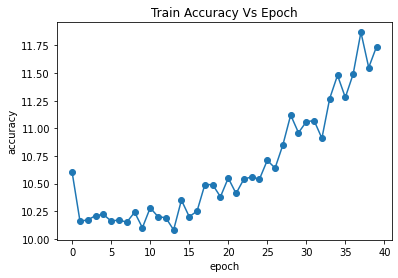

In [ ]:
#a. Report the plots for the training accuracy. [4 pt]
#b. What is the final training accuracy? [4 pt]
#c. What would be the expected accuracy for a random baseline model? [4 pt]
plt.plot(train_accu_list_rand,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy Vs Epoch')

plt.show()

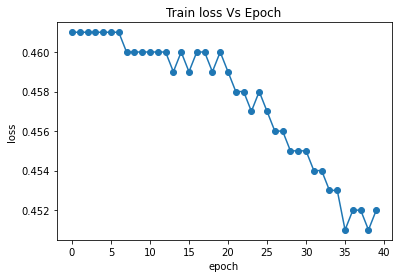

In [ ]:
#a. Report the plots for the training accuracy. [4 pt]
plt.plot(train_loss_list_rand,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train loss Vs Epoch')

plt.show()


Final training accuracy is around 11.6%

From the above experiments, we can also see the accuracy for baseline model can vary between 11 to 60%



In [ ]:
# For grader use only

# insert grade here
# G[2,1] =   
# G[2,2] = 
# G[2,3] =


maxScore = maxScore + 12


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 3.** Modifying the model for MNIST. </font>

Let's now work with the MNIST dataset. 
<br>

**a.** Download and prepare the dataloaders for the standard MNIST dataset. **[4 pt]** <br>
**b.** Modify the model so that it works with the MNIST dataset. The inner array sizes should be roughly similar, but you can adjust them in the way you choose **[8 pt]** <br>
**c.** Report the training and test accuracy after 10 epochs **[4 pt]**





In [ ]:
## your code goes here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # To use to cuba GPU

In [ ]:
###a. Download and prepare the dataloaders for the standard MNIST dataset. [4 pt]
###b. Modify the model so that it works with the MNIST dataset. The inner array sizes should be roughly similar, but you can adjust them in the way you choose [8 pt]
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
mnist_training_dataset = datasets.MNIST(root='./data_1', train=True, download=True, transform=transform)
mnist_validation_dataset = datasets.MNIST(root='./data_1', train=False, download=True, transform=transform)

mnist_training_loader = torch.utils.data.DataLoader(mnist_training_dataset, batch_size=100, shuffle=True)
mnist_validation_loader = torch.utils.data.DataLoader(mnist_validation_dataset, batch_size = 100, shuffle=False)

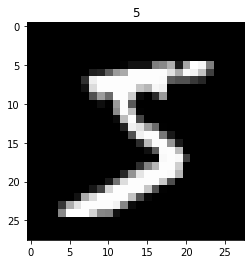

In [ ]:
plt.imshow(mnist_training_dataset.data[0], cmap='gray')
plt.title('%i' % mnist_training_dataset.targets[0])
plt.show()

In [ ]:
print(mnist_training_dataset.data.size())
print(mnist_validation_dataset.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [12]:
class CNN_M(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1) # Conv layer1
      self.conv2 = nn.Conv2d(20, 50, 5, 1) # Conv layer2
      self.fc1 = nn.Linear(4*4*50, 500)    # Fully connected layer1
      self.dropout1 = nn.Dropout(0.5)   # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      self.fc2 = nn.Linear(500, 10)   # Fully connected layer2
    def forward(self, x):
      x = F.relu(self.conv1(x))  # Apply ReLu to the feature maps produced after Conv 1 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 1 layer
      x = F.relu(self.conv2(x))  # Apply ReLu to the feature maps produced after Conv 2 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 2 layer
      x = x.view(-1, 4*4*50)     # Flattening the output of CNN to feed it into Fully connected layer
      x = F.relu(self.fc1(x))   # Fully connected layer 1 with Relu
      x = self.dropout1(x)     # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      x = self.fc2(x)         # Fully connected layer 2 with no activation funct as we need raw output from CrossEntropyLoss
      return x

In [13]:
model = CNN_M().to(device)
model

CNN_M(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in mnist_training_loader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in mnist_validation_loader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(mnist_training_loader)
    epoch_acc = running_corrects.float()/ len(mnist_training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc.cpu())
    
    val_epoch_loss = val_running_loss/len(mnist_validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(mnist_validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0336, acc 98.9850 
validation loss: 0.0322, validation acc 98.8800 
epoch : 2
training loss: 0.0316, acc 99.0000 
validation loss: 0.0309, validation acc 98.9700 
epoch : 3
training loss: 0.0284, acc 99.1583 
validation loss: 0.0296, validation acc 99.0800 
epoch : 4
training loss: 0.0263, acc 99.1950 
validation loss: 0.0306, validation acc 98.9100 
epoch : 5
training loss: 0.0239, acc 99.2500 
validation loss: 0.0296, validation acc 99.0600 
epoch : 6
training loss: 0.0229, acc 99.3133 
validation loss: 0.0272, validation acc 99.1200 
epoch : 7
training loss: 0.0210, acc 99.3267 
validation loss: 0.0277, validation acc 99.0600 
epoch : 8
training loss: 0.0207, acc 99.3183 
validation loss: 0.0273, validation acc 99.1200 
epoch : 9
training loss: 0.0188, acc 99.4233 
validation loss: 0.0279, validation acc 99.0900 
epoch : 10
training loss: 0.0180, acc 99.4300 
validation loss: 0.0253, validation acc 99.2000 


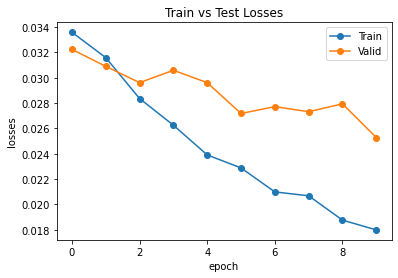

In [ ]:
plt.plot(running_loss_history,'-o')
plt.plot(val_running_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Losses')

plt.show()

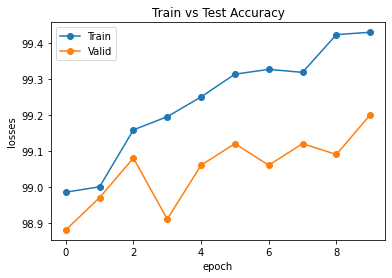

In [ ]:
plt.plot(running_corrects_history,'-o')
plt.plot(val_running_corrects_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Accuracy')

plt.show()

In [ ]:
# For grader use only

# insert grade here
# G[3,1] =   
# G[3,2] = 
# G[3,3] =


maxScore = maxScore + 16


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 4.** MNIST on randomly permuted images. </font>

In this question we will see whether a CNN remains as effective for randomly permuted images. 
<br>

**a.** Find a way to randomly permute the entries of a 2d array in numpy or a 2d tensor in PyTorch. This should be 2-3 lines of code - feel free to discuss it on Canvas. **[4 pt]** <br>
**b.** Train the model from question 3 on a training set where the images in the training set have re-arranged in a **random** way, which however is the **same** across all images. **[8 pt]** <br>
**c.** Report the training and test accuracy after 10 epochs, and after 20 epochs. **[4 pt]**





In [ ]:
#a. Find a way to randomly permute the entries of a 2d array in numpy or a 2d tensor in PyTorch. This should be 2-3 lines of code - feel free to discuss it on Canvas. [4 pt]
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
MNISTtrainset = datasets.MNIST(root='./data_1', train=True, download=True, transform=transform)
MNISTtestset = datasets.MNIST(root='./data_1', train=False, download=True, transform=transform)

p1 = torch.randperm(28) #for permuting the pixels randomly
p2 = torch.randperm(28)

plt.imshow(MNISTtrainset.data[0], cmap='gray')
plt.show()

for i in range(len(MNISTtrainset)):
  tmp = MNISTtrainset.data[i]
  shuffle_img = tmp[p1,p2[:,None]]
  MNISTtrainset.data[i] = shuffle_img

for i in range(len(MNISTtestset)):
  tmp = MNISTtestset.data[i]
  shuffle_img = tmp[p1,p2[:,None]]
  MNISTtestset.data[i]=shuffle_img

plt.imshow(MNISTtrainset.data[0], cmap='gray')
plt.show()  

In [8]:
shuffle_mnist_training_loader = torch.utils.data.DataLoader(MNISTtrainset, batch_size=100, shuffle=True)
shuffle_mnist_validation_loader = torch.utils.data.DataLoader(MNISTtrainset, batch_size = 100, shuffle=False)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # To use to cuba GPU

In [ ]:
#b. Train the model from question 3 on a training set where the images in the training set have re-arranged in a random way, which however is the same across all images. [8 pt]
#c. Report the training and test accuracy after 10 epochs, and after 20 epochs. [4 pt]

In [15]:
epochs = 10
shuffle_running_loss_history = []
shuffle_running_corrects_history = []
shuffle_val_running_loss_history = []
shuffle_val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in shuffle_mnist_training_loader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in shuffle_mnist_validation_loader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(shuffle_mnist_training_loader)
    epoch_acc = running_corrects.float()/ len(shuffle_mnist_training_loader)
    shuffle_running_loss_history.append(epoch_loss)
    shuffle_running_corrects_history.append(epoch_acc.cpu())
    
    val_epoch_loss = val_running_loss/len(shuffle_mnist_validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(shuffle_mnist_validation_loader)
    shuffle_val_running_loss_history.append(val_epoch_loss)
    shuffle_val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.0412, acc 67.5733 
validation loss: 0.5223, validation acc 84.1200 
epoch : 2
training loss: 0.4409, acc 86.6550 
validation loss: 0.3356, validation acc 89.8300 
epoch : 3
training loss: 0.3142, acc 90.4983 
validation loss: 0.2548, validation acc 92.2000 
epoch : 4
training loss: 0.2466, acc 92.5150 
validation loss: 0.2091, validation acc 93.8100 
epoch : 5
training loss: 0.2085, acc 93.6617 
validation loss: 0.1785, validation acc 94.6900 
epoch : 6
training loss: 0.1813, acc 94.4333 
validation loss: 0.1606, validation acc 95.0800 
epoch : 7
training loss: 0.1591, acc 95.1833 
validation loss: 0.1406, validation acc 95.6000 
epoch : 8
training loss: 0.1450, acc 95.5933 
validation loss: 0.1359, validation acc 95.7300 
epoch : 9
training loss: 0.1309, acc 96.0300 
validation loss: 0.1266, validation acc 96.2300 
epoch : 10
training loss: 0.1214, acc 96.2217 
validation loss: 0.1213, validation acc 96.1100 


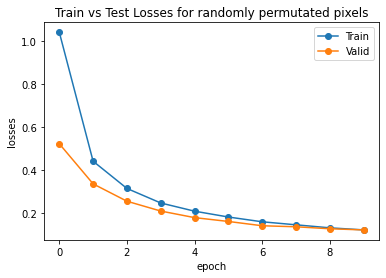

In [17]:
plt.plot(shuffle_running_loss_history,'-o')
plt.plot(shuffle_val_running_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Losses for randomly permutated pixels')

plt.show()

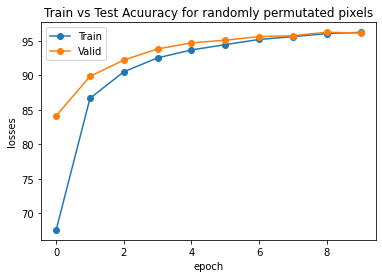

In [18]:
plt.plot(shuffle_running_corrects_history,'-o')
plt.plot(shuffle_val_running_corrects_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Acuuracy for randomly permutated pixels')

plt.show()

In [19]:
epochs = 20
shuffle_running_loss_history = []
shuffle_running_corrects_history = []
shuffle_val_running_loss_history = []
shuffle_val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in shuffle_mnist_training_loader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in shuffle_mnist_validation_loader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(shuffle_mnist_training_loader)
    epoch_acc = running_corrects.float()/ len(shuffle_mnist_training_loader)
    shuffle_running_loss_history.append(epoch_loss)
    shuffle_running_corrects_history.append(epoch_acc.cpu())
    
    val_epoch_loss = val_running_loss/len(shuffle_mnist_validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(shuffle_mnist_validation_loader)
    shuffle_val_running_loss_history.append(val_epoch_loss)
    shuffle_val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.1117, acc 96.5750 
validation loss: 0.1060, validation acc 96.7200 
epoch : 2
training loss: 0.1046, acc 96.8117 
validation loss: 0.1051, validation acc 96.6600 
epoch : 3
training loss: 0.0983, acc 96.9650 
validation loss: 0.1022, validation acc 96.7900 
epoch : 4
training loss: 0.0917, acc 97.1533 
validation loss: 0.0986, validation acc 96.8000 
epoch : 5
training loss: 0.0865, acc 97.2967 
validation loss: 0.0937, validation acc 97.0300 
epoch : 6
training loss: 0.0822, acc 97.4400 
validation loss: 0.0885, validation acc 97.0000 
epoch : 7
training loss: 0.0770, acc 97.6100 
validation loss: 0.0975, validation acc 96.8500 
epoch : 8
training loss: 0.0720, acc 97.7217 
validation loss: 0.0870, validation acc 97.1200 
epoch : 9
training loss: 0.0687, acc 97.8517 
validation loss: 0.0861, validation acc 97.1800 
epoch : 10
training loss: 0.0653, acc 97.9617 
validation loss: 0.0848, validation acc 97.3200 
epoch : 11
training loss: 0.0615, acc 98.0650 
va

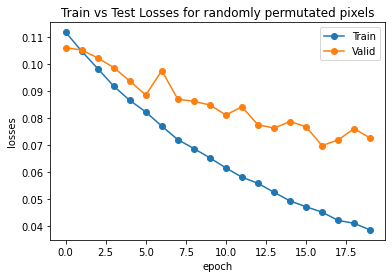

In [20]:
plt.plot(shuffle_running_loss_history,'-o')
plt.plot(shuffle_val_running_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Losses for randomly permutated pixels')

plt.show()

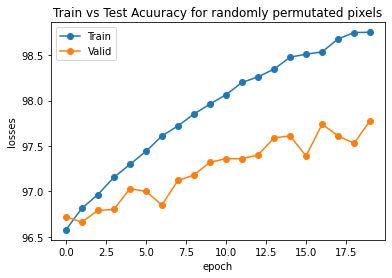

In [21]:
plt.plot(shuffle_running_corrects_history,'-o')
plt.plot(shuffle_val_running_corrects_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Acuuracy for randomly permutated pixels')

plt.show()

In [ ]:
# For grader use only

# insert grade here
# G[4,1] =   
# G[4,2] = 
# G[4,3] =


maxScore = maxScore + 16


In [ ]:
# for grader use

# Total Grade Calculation
rawScore = np.sum(G)
score = rawScore*100/maxScore